In [54]:
# !pip install torch
# !pip3 install torch_geometric
# !pip install torch torchvision
# !pip3 install tensorboard

# !pip3 install tensorflow==2.9.1
# !pip3 install tensorboardX
# !pip3 install numpy
# !pip3 install --upgrade h5py
# !pip3 install protobuf==3.20.0
!pip3 install matplotlib

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [55]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F

# num_classes = 3
# edge_index = torch.tensor([[0, 1, 1, 2, 3, 2],
#                            [1, 0, 2, 1, 2, 3]], dtype=torch.long)
# x = torch.tensor([[], [], [], []], dtype=torch.float)
# y = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]], dtype=torch.float)
# train_mask = torch.tensor([True, True, False, False], dtype=torch.bool)
# test_mask = torch.tensor([False, False, True, True], dtype=torch.bool)
# x
# data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
# data

In [56]:
from torch.utils.data import random_split

data = torch.load('sample_GNN_data_800_1600.pt')

# Assuming 'dataset' is your entire dataset
dataset_size = data.x.shape[0]
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(data.x, [train_size, test_size])

# Now you can create masks based on the lengths of train_dataset and test_dataset
train_mask = torch.zeros(dataset_size, dtype=torch.bool)
test_mask = torch.zeros(dataset_size, dtype=torch.bool)
train_mask[list(train_dataset.indices)] = True
test_mask[list(test_dataset.indices)] = True

data.test_mask = test_mask
data.train_mask = train_mask
num_classes = data.y.shape[1]
print(dict(zip(data.categories, data.y_weights)))
data

{'Baked foods': tensor(1.7769), 'Smoked meat': tensor(1.1895), 'Breaded cutlets': tensor(2.6169), 'Casserole dishes': tensor(0.8776), 'Easter bread': tensor(2.5702), 'Sweet breads': tensor(0.4032), 'Yeast breads': tensor(0.4879), 'Savory puddings': tensor(1.8938), 'Fried foods': tensor(1.3708), 'Chinese breads': tensor(1.9191), 'Flatbreads': tensor(0.3890), 'Baked goods': tensor(1.8938), 'Deep fried foods': tensor(0.2129), 'Sponge cakes': tensor(1.6933), 'Breads': tensor(0.7822), 'Jewish baked goods': tensor(1.0506), 'Puff pastry': tensor(2.6654), 'Savoury pies': tensor(0.7343), 'Jewish breads': tensor(1.3327), 'Bread stubs': tensor(0.3788), 'Buns': tensor(1.2197), 'Bread dishes': tensor(1.3327), 'Pizza styles': tensor(2.4815), 'Twice-baked goods': tensor(2.6169), 'Biscuits': tensor(0.2890), 'Cookies': tensor(0.4846), 'Almond cookies': tensor(1.2408), 'Biscuit brands': tensor(0.7090), 'Crackers (food)': tensor(0.9286), 'Philippine breads': tensor(2.8786), 'Shortbread': tensor(1.1994), 

Data(x=[499, 384], edge_index=[2, 582], edge_attr=[582], y=[499, 71], y_weights=[71], articles=[499], categories=[71], test_mask=[499], train_mask=[499])

In [57]:
node1 = data.edge_index[0][9]
node2 = data.edge_index[1][9]
print(data.articles[node1])
print(data.articles[node2])
print(data.edge_attr[9])

Flatbread
Lagana (bread)
tensor(0.5070)


In [58]:
# tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [59]:
import torch_geometric.nn

class GCNModel(torch.nn.Module):
    def __init__(self, num_nodes, hidden_size=128):
        super(GCNModel, self).__init__()
        self.node_embedding = torch.nn.Embedding(num_nodes, hidden_size)
        # Initialize the embeddings with small random values
        torch.nn.init.normal_(self.node_embedding.weight, std=0.1)
        # self.conv1 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv1 = torch_geometric.nn.GCNConv(hidden_size, 16)
        self.conv2 = torch_geometric.nn.GCNConv(16, num_classes)

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        # x = self.node_embedding.weight
        x = data.x

        # x = self.conv1(x, edge_index)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.softmax(x, dim=1)
    
class GCNModelNodeFeat(torch.nn.Module):
    def __init__(self, num_nodes, num_features, hidden_size=128):
        super(GCNModelNodeFeat, self).__init__()
        # self.conv1 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv1 = torch_geometric.nn.GCNConv(num_features, hidden_size)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv3 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv4 = torch_geometric.nn.GCNConv(hidden_size, num_classes)

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        # x = self.node_embedding.weight
        x = data.x

        # x = self.conv1(x, edge_index)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index, edge_attr)
        return F.softmax(x, dim=1)

In [60]:
from sklearn.metrics import f1_score, precision_score, recall_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GCNModel(len(data.x)).to(device)
print(data.x.shape[1])
model = GCNModelNodeFeat(len(data.x), data.x.shape[1]).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# sets the model in training mode
# When you call model.train(), PyTorch enables features such as dropout and 
# batch normalization, which are typically used during training but not during inference
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=data.y_weights)
    loss.backward()
    if(epoch % 10 == 0):
        print(epoch, loss)
    writer.add_scalar("Loss/train", loss, epoch)
    
    max_index = torch.argmax(out, dim=1)
    binary_pred = torch.zeros_like(out)
    binary_pred[torch.arange(out.size(0)), max_index] = 1
    precision = precision_score(data.y[data.train_mask], binary_pred[data.train_mask], average='micro')
    writer.add_scalar("Precision/train", precision, epoch)
    recall = recall_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
    writer.add_scalar("Recall/train", recall, epoch)
    f1 = f1_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
    writer.add_scalar("F1/train", f1, epoch)
    
    optimizer.step()

writer.flush()

384
0 tensor(8.0093, grad_fn=<DivBackward1>)
10 tensor(7.9202, grad_fn=<DivBackward1>)
20 tensor(7.9163, grad_fn=<DivBackward1>)
30 tensor(7.9068, grad_fn=<DivBackward1>)
40 tensor(7.8988, grad_fn=<DivBackward1>)
50 tensor(7.8494, grad_fn=<DivBackward1>)
60 tensor(7.7727, grad_fn=<DivBackward1>)
70 tensor(7.7536, grad_fn=<DivBackward1>)
80 tensor(7.6841, grad_fn=<DivBackward1>)
90 tensor(7.6326, grad_fn=<DivBackward1>)
100 tensor(7.6213, grad_fn=<DivBackward1>)
110 tensor(7.6547, grad_fn=<DivBackward1>)
120 tensor(7.6048, grad_fn=<DivBackward1>)
130 tensor(7.5960, grad_fn=<DivBackward1>)
140 tensor(7.5866, grad_fn=<DivBackward1>)
150 tensor(7.5899, grad_fn=<DivBackward1>)
160 tensor(7.5584, grad_fn=<DivBackward1>)
170 tensor(7.5487, grad_fn=<DivBackward1>)
180 tensor(7.5532, grad_fn=<DivBackward1>)
190 tensor(7.5590, grad_fn=<DivBackward1>)
200 tensor(7.5374, grad_fn=<DivBackward1>)
210 tensor(7.5567, grad_fn=<DivBackward1>)
220 tensor(7.5440, grad_fn=<DivBackward1>)
230 tensor(7.5270,

In [68]:
model.eval()
pred = model(data)

max_index = torch.argmax(pred, dim=1)
# binary_pred = torch.zeros_like(pred)
# binary_pred[torch.arange(pred.size(0)), max_index] = 1
binary_pred = (pred >= 10.0/num_classes).float()

# print(binary_pred)
# print(data.y)
# print(max_index)

for i in range(20):
    print(data.articles[i])
    boolean_mask = binary_pred[i] == 1.0
    filtered_categories = [category for category, mask in zip(data.categories, boolean_mask) if mask]
    print(filtered_categories)

# Check if each prediction matches the label for each instance
correct = torch.as_tensor([int(data.y[i, idx]) for i, idx in enumerate(max_index)])
# print(correct[data.test_mask])
acc = correct[data.test_mask].sum() / len(correct[data.test_mask])
print(f'Accuracy: {acc:.4f}')

precision = precision_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'Precision: {precision:.4f}')
recall = recall_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'Recall: {recall:.4f}')
f1 = f1_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'F1 Score: {f1:.4f}')

Tsoureki
['Cakes']
Aparon
['Rice cakes']
Bakarkhani
['Indian breads']
Balep korkun
['Cakes']
Bammy
['Unleavened breads', 'Rice cakes']
Bannock (British and Irish food)
['American breads']
Bannock (Indigenous American food)
['American breads']
Barbari bread
['American breads', 'Unleavened breads']
Bazlama
['Cakes', 'American breads']
Bhakri
['Indian breads']
Bhatura
['Indian breads']
Bing (bread)
['American breads', 'Unleavened breads']
Bolani
['Rice cakes']
Bolo do caco
['Rice cakes']
Cañada bread
['American breads']
Chapati
['Indian breads']
Christmas wafer
['Cakes']
Corn tortilla
['American breads']
Crescia
['Italian breads']
Eish merahrah
['Rice cakes']
Accuracy: 0.2400
Precision: 0.2212
Recall: 0.1366
F1 Score: 0.1689


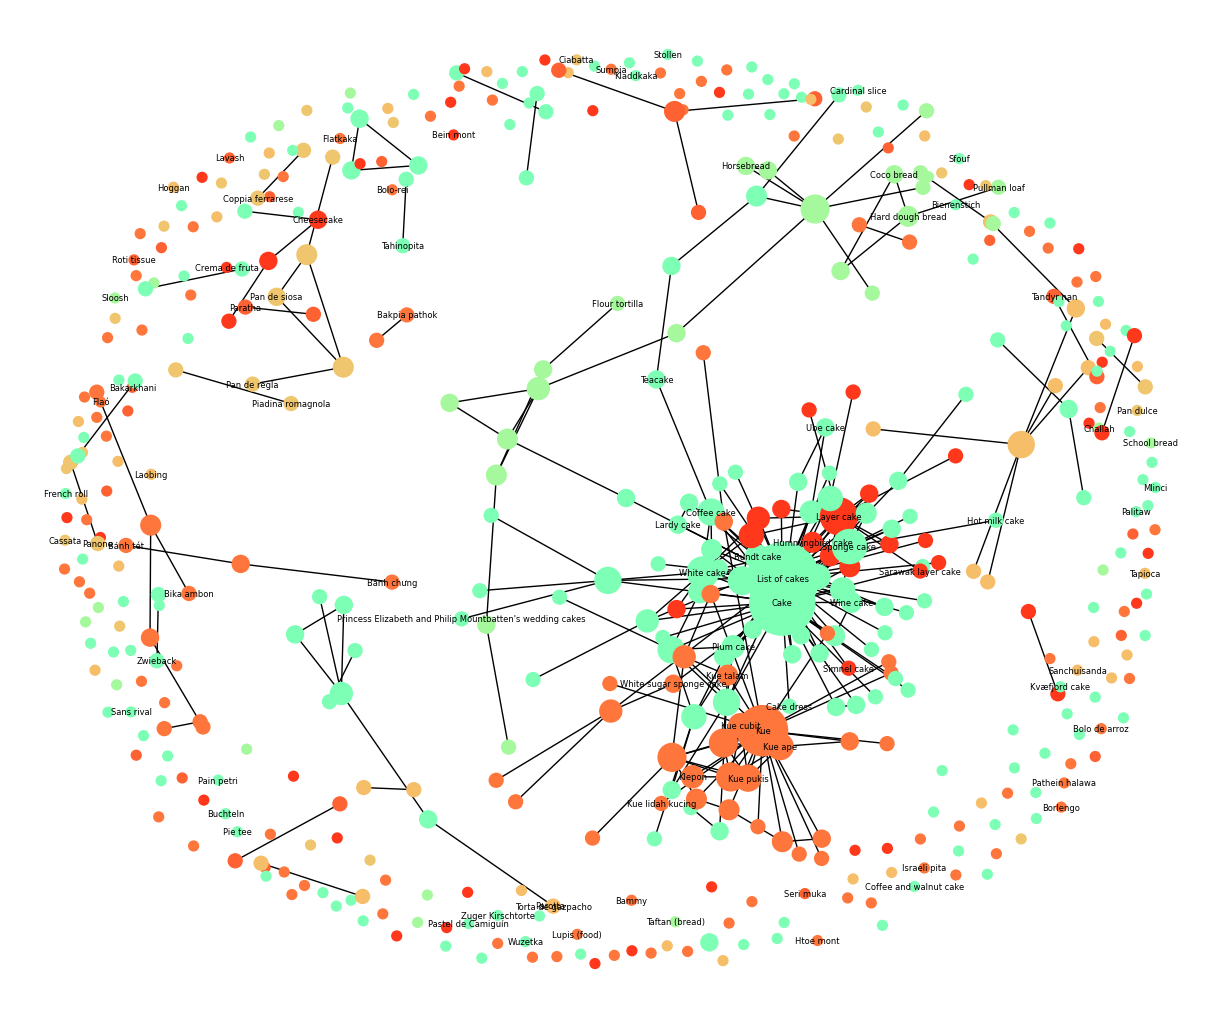

In [62]:
import networkx as nx
import torch_geometric.utils
import matplotlib.pyplot as plt
import matplotlib.cm
from numpy import random

g = torch_geometric.utils.to_networkx(data, to_undirected=True)

node_list = dict(map(lambda i,j : (i,j) , g.nodes, data.articles))
font_size = 6

degrees = dict(g.degree).values()
node_size = [(d+1) * 50 for d in degrees]

idx = 0
for n, l in node_list.items():
    node_list[n] = l if node_size[idx] > 400 else (l if node_size[idx] > 200 and random.rand() > 0.95 else (l if random.rand() > 0.85 else ''))
    idx += 1

pred_list = [p.tolist() for p in pred]
node_pred = [float(p.index(max(p))) for p in pred_list]
node_color = [matplotlib.cm.get_cmap('rainbow')(p/num_classes) for p in node_pred]

fig = plt.figure(1, figsize=(12, 10), dpi=100)
nx.draw(g, labels=node_list, pos=nx.spring_layout(g, k=0.2, iterations=50), font_size=font_size, node_size=node_size, node_color=node_color)